## 2. Nonlinear Optimization

In [263]:
using PyPlot
using Formatting
using Random
using LinearAlgebra
using Printf
using ForwardDiff

include("../ovm/plot/plot_nonlinopt_result.jl")

Random.seed!(1234);

In [225]:
function f_obs(x)
    return 1/2*x[1]^4-2*x[1]^2*x[2]+4*x[2]^2+8*x[1]+8x[2]
end

x_opt = [-1.36471, -0.534426]

2-element Array{Float64,1}:
 -1.36471 
 -0.534426

In [264]:
function backtrack_linesearch(x, grad_f, d, rho, c1, alpha0)
   
    # step 0
    alpha = alpha0
    
    while true
        
        # step 1
        l = f_obs(x + alpha .* d)
        if l <= f_obs(x) + c1 * dot(grad_f, d) * alpha
            return alpha
        end

        # step 2
        alpha = rho * alpha        

    end 
        
end

function incremental_linesearch(x, grad_f, d, h, c1, alpha0)
   
    # step 0
    alpha = alpha0
    
    while true
        
        # step 1
        l = f_obs(x + alpha .* d)
        if l <= f_obs(x) + c1 * dot(grad_f, d) * alpha
            return alpha
        end

        # step 2
        alpha = alpha + h * alpha        

    end 
        
end

incremental_linesearch (generic function with 1 method)

### Example 2.5 Gradient descent method

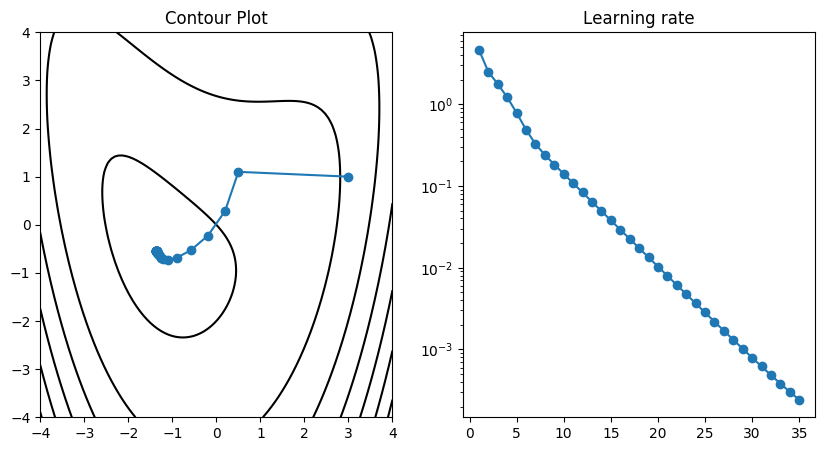

[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Solution: [-1.36455, -0.534604]


In [265]:
# 評価関数とその勾配
f(x::Vector) = f_obs(x)
g = x -> ForwardDiff.gradient(f, x)

# 初期解の設定
x0 = [3, 1]
#println(-g(x0)) # 初期解x0における探索方向

# 最適解の計算
loop_num = 50
alpha0 = 0.05
c1 = 0.05
rho = 0.5
epsilon = 0.001
x_history = x0
alpha_history = [alpha0]
xn = x0
for i in 1:loop_num
   
    # step 1
    if norm(g(xn)) < epsilon
        break
    end
    
    # step 2
    dn = -g(xn)                                                  # 勾配を計算
    
    # step 3
    alpha = backtrack_linesearch(xn, g(xn), dn, rho, c1, alpha0) # 直線探索
    
    # step 4
    xn = xn + alpha .* dn                                        # 更新
    
    x_history = hcat(x_history, xn)
    append!(alpha_history, alpha)
end

println(alpha_history)

print("Solution: ")
println(xn)

# 収束過程の計算
x_error = []
for i in 1:length(x_history[1, :])
    append!(x_error, norm(x_history[:, i] - x_opt) )
end

# plot
plot_nonlinopt_result(100, [-4, 4], [-4, 4], x_history, x_error, f_obs)

### Example 2.6 Newton method

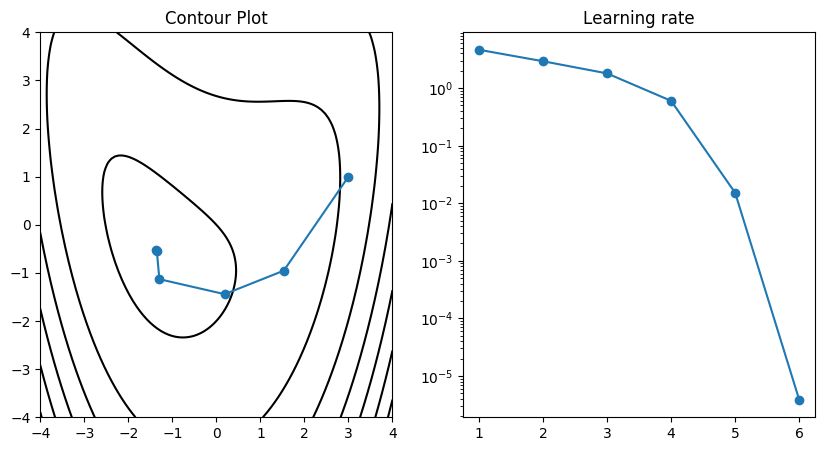

Solution: [-1.36471, -0.534426]


In [266]:
# 評価関数とその勾配
f(x::Vector) = f_obs(x)
g = x -> ForwardDiff.gradient(f, x)
h = x -> ForwardDiff.hessian(f, x)

# 初期解の設定
x0 = [3, 1]

# 最適解の計算
loop_num = 50
alpha = 1.0
epsilon = 0.001
x_history = x0
xn = x0
for i in 1:loop_num
       
    # step 1
    if norm(g(xn)) < epsilon
        break
    end

    # step 2
    dn = h(xn) \ (-g(xn))  # 勾配を計算 
    
    # step 3
    xn = xn + alpha .* dn  # 更新
    
    x_history = hcat(x_history, xn)
end

print("Solution: ")
println(xn)

# 収束過程の計算
x_error = []
for i in 1:length(x_history[1, :])
    append!(x_error, norm(x_history[:, i] - x_opt) )
end

# plot
plot_nonlinopt_result(100, [-4, 4], [-4, 4], x_history, x_error, f_obs)

### Example 2.7 Quasi-Newton method

### B formula

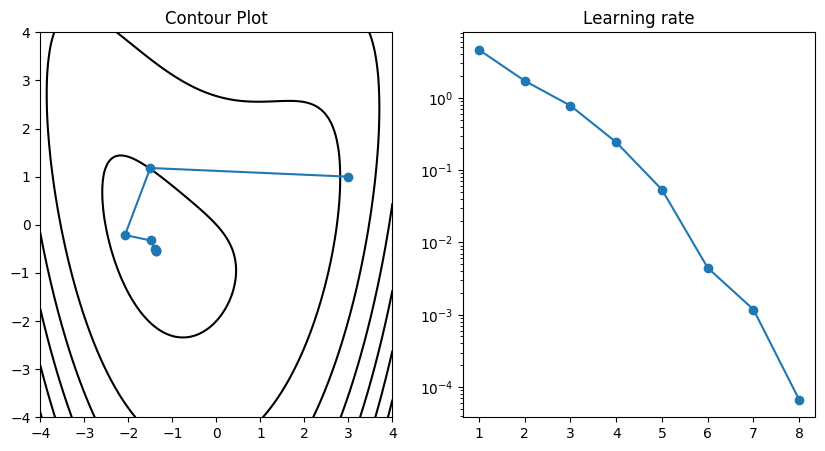

[1.0, 0.09, 0.09, 1.0, 1.0, 1.0, 1.0, 1.0]
Solution: [-1.36465, -0.534449]


In [267]:
# 評価関数とその勾配
f(x::Vector) = f_obs(x)
g = x -> ForwardDiff.gradient(f, x)
h = x -> ForwardDiff.hessian(f, x)

# 初期解の設定
x0 = [3, 1]

# 最適解の計算
loop_num = 50
alpha0 = 1.0
c1 = 0.05
rho = 0.09
B0 = Matrix{Float64}(I, 2, 2)
epsilon = 0.001

x_history = x0
alpha_history = [alpha0]
xn = x0
Bn = B0
for i in 1:loop_num
       
    # step 1
    if norm(g(xn)) < epsilon
        break
    end
    
    # step 2
    dn = Bn \ (-g(xn))  # 勾配を計算
    
    # step 3
    alpha = backtrack_linesearch(xn, g(xn), dn, rho, c1, alpha0) # 直線探索
    
    # step 4
    xn_plus = xn + alpha .* dn  # 更新
    
    # step 5
    sn = xn_plus - xn
    yn = g(xn_plus) - g(xn)
    Bn = Bn - ( (Bn * sn) *  (Bn * sn)' ) / (dot(Bn * sn, sn)) + (yn * yn') / dot(yn, sn) #BFGS
    #Bn = Bn - (yn * sn' * Bn + Bn * sn * yn') / dot(yn, sn) + (1 + dot(Bn * sn, sn) / dot(yn, sn)) * ( (yn * yn') / dot(yn, sn) ) #DFP
    
    xn = xn_plus
    x_history = hcat(x_history, xn)
    append!(alpha_history, alpha)
end

println(alpha_history)

print("Solution: ")
println(xn)

# 収束過程の計算
x_error = []
for i in 1:length(x_history[1, :])
    append!(x_error, norm(x_history[:, i] - x_opt) )
end

# plot
plot_nonlinopt_result(100, [-4, 4], [-4, 4], x_history, x_error, f_obs)

### H formula

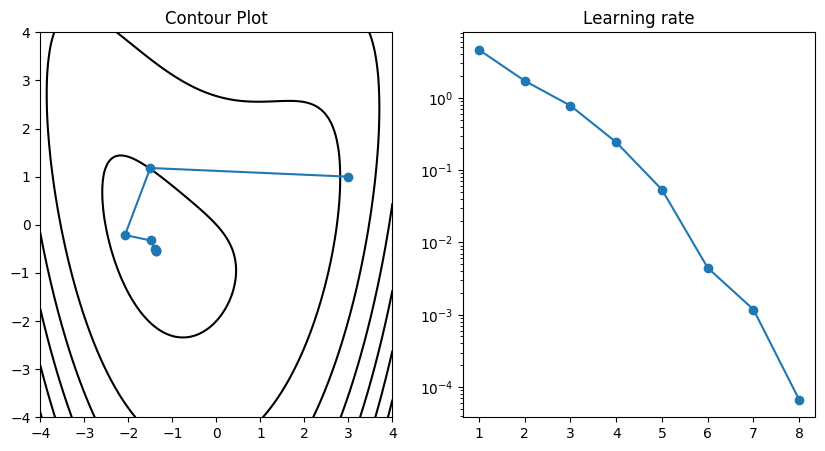

[1.0, 0.09, 0.09, 1.0, 1.0, 1.0, 1.0, 1.0]
Solution: [-1.36465, -0.534449]


In [268]:
# 評価関数とその勾配
f(x::Vector) = f_obs(x)
g = x -> ForwardDiff.gradient(f, x)
h = x -> ForwardDiff.hessian(f, x)

# 初期解の設定
x0 = [3, 1]

# 最適解の計算
loop_num = 50
alpha0 = 1.0
c1 = 0.05
rho = 0.09
H0 = Matrix{Float64}(I, 2, 2)
epsilon = 0.001

x_history = x0
alpha_history = [alpha0]
xn = x0
Hn = H0
for i in 1:loop_num
       
    # step 1
    if norm(g(xn)) < epsilon
        break
    end
    
    # step 2
    dn = Hn * (-g(xn))  # 勾配を計算
    
    # step 3
    alpha = backtrack_linesearch(xn, g(xn), dn, rho, c1, alpha0) # 直線探索
    
    # step 4
    xn_plus = xn + alpha .* dn  # 更新
    
    # step 5
    sn = xn_plus - xn
    yn = g(xn_plus) - g(xn)
    Hn = Hn - (sn * yn' * Hn + Hn * yn * sn') / dot(yn, sn) + (1 + dot(yn, Hn * yn) / dot(yn, sn)) * ( (sn * sn') / dot(yn, sn) ) #BFGS
    #Hn = Hn - ( (Hn * yn) *  (Hn * yn)' ) / (dot(yn, Hn * yn)) + (sn * sn') / dot(yn, sn) #DFP
    
    xn = xn_plus
    x_history = hcat(x_history, xn)
    append!(alpha_history, alpha)
end

println(alpha_history)

print("Solution: ")
println(xn)

# 収束過程の計算
x_error = []
for i in 1:length(x_history[1, :])
    append!(x_error, norm(x_history[:, i] - x_opt) )
end

# plot
plot_nonlinopt_result(100, [-4, 4], [-4, 4], x_history, x_error, f_obs)

### Appendix 1:  Trust region method

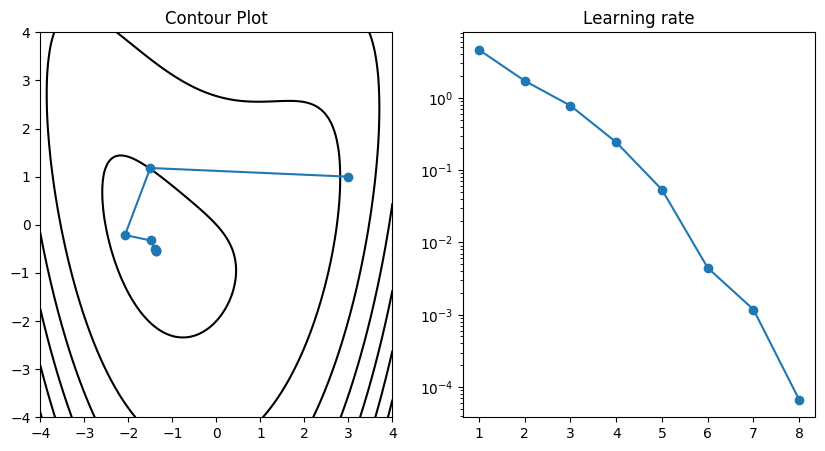

[1.0, 0.09, 0.09, 1.0, 1.0, 1.0, 1.0, 1.0]
Solution: [-1.36465, -0.534449]


In [269]:
# in progress

# 評価関数とその勾配
f(x::Vector) = f_obs(x)
g = x -> ForwardDiff.gradient(f, x)
h = x -> ForwardDiff.hessian(f, x)

# 初期解の設定
x0 = [3, 1]

# 最適解の計算
loop_num = 50
alpha0 = 1.0
rho = 0.09

delta0 = 0.5
c1 = 0.05
c2 = 0.05
c3 = 0.05
c4 = 0.05

H0 = Matrix{Float64}(I, 2, 2)
epsilon = 0.001

x_history = x0
alpha_history = [alpha0]
xn = x0
Hn = H0
for i in 1:loop_num
       
    # step 1
    if norm(g(xn)) < epsilon
        break
    end
    
    # step 2
    dn = Hn * (-g(xn))  # 勾配を計算
    
    # step 3
    alpha = backtrack_linesearch(xn, g(xn), dn, rho, c1, alpha0) # 直線探索
    
    # step 4
    xn_plus = xn + alpha .* dn  # 更新
    
    # step 5
    sn = xn_plus - xn
    yn = g(xn_plus) - g(xn)
    Hn = Hn - (sn * yn' * Hn + Hn * yn * sn') / dot(yn, sn) + (1 + dot(yn, Hn * yn) / dot(yn, sn)) * ( (sn * sn') / dot(yn, sn) ) #BFGS
    #Hn = Hn - ( (Hn * yn) *  (Hn * yn)' ) / (dot(yn, Hn * yn)) + (sn * sn') / dot(yn, sn) #DFP
    
    xn = xn_plus
    x_history = hcat(x_history, xn)
    append!(alpha_history, alpha)
end

println(alpha_history)

print("Solution: ")
println(xn)

# 収束過程の計算
x_error = []
for i in 1:length(x_history[1, :])
    append!(x_error, norm(x_history[:, i] - x_opt) )
end

# plot
plot_nonlinopt_result(100, [-4, 4], [-4, 4], x_history, x_error, f_obs)

### Appendix 2: Conjugate descent method

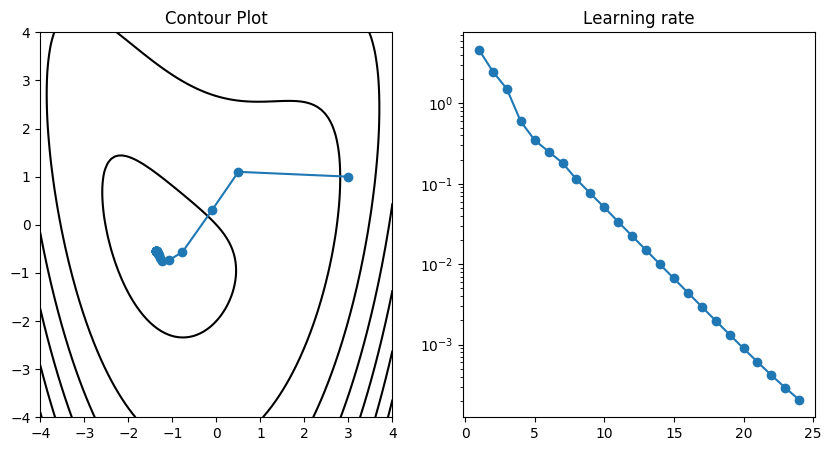

[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
Solution: [-1.36457, -0.534573]


In [261]:
# 評価関数とその勾配
f(x::Vector) = f_obs(x)
g = x -> ForwardDiff.gradient(f, x)

# 初期解の設定
x0 = [3, 1]
#println(-g(x0)) # 初期解x0における探索方向

# 最適解の計算
loop_num = 50
alpha0 = 0.05
c1 = 0.05
rho = 0.5
epsilon = 0.001

x_history = x0
alpha_history = [alpha0]
xn = x0
sn = -g(xn)
for i in 1:loop_num

    dn = sn
    
    # step 1
    if norm(g(xn)) < epsilon
        break
    end
    
    # step 2    
    alpha = backtrack_linesearch(xn, g(xn), dn, rho, c1, alpha0) # 直線探索    
    
    # step 3
    xn_plus = xn + alpha .* sn                                   # 更新
    
    # step 4
    dn_plus = -g(xn_plus)
    #beta = dn_plus' * (dn_plus - dn) / norm(dn)^2
    beta = norm(dn_plus)^2 / norm(dn)^2
    sn = dn_plus + beta * sn

    xn = xn_plus
    x_history = hcat(x_history, xn)
    append!(alpha_history, alpha)
end

println(alpha_history)

print("Solution: ")
println(xn)

# 収束過程の計算
x_error = []
for i in 1:length(x_history[1, :])
    append!(x_error, norm(x_history[:, i] - x_opt) )
end

# plot
plot_nonlinopt_result(100, [-4, 4], [-4, 4], x_history, x_error, f_obs)

### Appendix 3: Modified Newton Method

### Appendix 4: Gauss-Newton method

### Appendix 5: Levenberg-Markart Method

### Example 2.8-2.11

In [262]:
# 数式例のため省略

### Example 2.12